In [1]:
from qiskit import QuantumRegister, QuantumCircuit

qubits = QuantumRegister(2, name="q")
circuit = QuantumCircuit(qubits)

q0, q1 = qubits
circuit.h(q0)
circuit.cx(q0, q1)
circuit.measure_all()

circuit.draw()

┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1

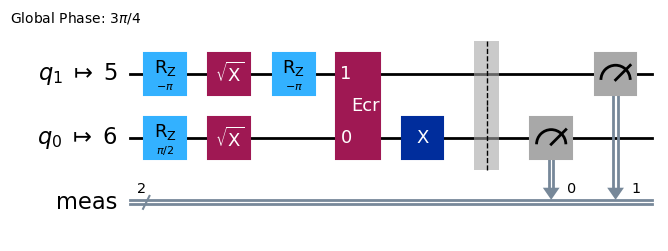

In [2]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

ibm_quantum_token = os.getenv("IBM_QUANTUM_TOKEN")

QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token=ibm_quantum_token,
    set_as_default=True,
    # Use 'overwrite=True' if you're updating your token.
    overwrite=True,
)

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)
isa_circuit = pass_manager.run(circuit)

isa_circuit.draw("mpl", idle_wires=False)

In [8]:
# sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_ibm_runtime import SamplerV2

fake_manila = FakeManilaV2()
pm = generate_preset_pass_manager(backend=fake_manila, optimization_level=1)
isa_qc = pm.run(circuit)

# fixed seed
options = {"simulator": {"seed_simulator": 42}}
sampler = SamplerV2(mode=fake_manila, options=options)

results = sampler.run([isa_qc]).result()
results

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=2>)))], metadata={})

In [9]:
!nvidia-smi

Mon Jul 15 13:37:53 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:C3:00.0 Off |                    0 |
| N/A   75C    P0   246W / 250W |  39867MiB / 40960MiB |    100%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
# test cuda aer
from qiskit import transpile
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator

sim = AerSimulator()
# --------------------------
# Simulating using estimator
#---------------------------
from qiskit_aer.primitives import EstimatorV2

psi1 = transpile(RealAmplitudes(num_qubits=2, reps=2), sim, optimization_level=0)
psi2 = transpile(RealAmplitudes(num_qubits=2, reps=3), sim, optimization_level=0)

H1 = SparsePauliOp.from_list([("II", 1), ("IZ", 2), ("XI", 3)])
H2 = SparsePauliOp.from_list([("IZ", 1)])
H3 = SparsePauliOp.from_list([("ZI", 1), ("ZZ", 1)])

theta1 = [0, 1, 1, 2, 3, 5]
theta2 = [0, 1, 1, 2, 3, 5, 8, 13]
theta3 = [1, 2, 3, 4, 5, 6]

estimator = EstimatorV2()

job = estimator.run(
    [
        (psi1, [H1, H3], [theta1, theta3]),
        (psi2, H2, theta2)
    ],
    precision=0.01
)
result = job.result()
print(f"expectation values : psi1 = {result[0].data.evs}, psi2 = {result[1].data.evs}")

ImportError: /global/homes/g/gzquse/.conda/envs/qiskit-summer/lib/python3.11/site-packages/qiskit_aer/backends/../../nvidia/cusparse/lib/libcusparse.so.12: undefined symbol: __nvJitLinkAddData_12_5, version libnvJitLink.so.12